Aufgabe 21.
>Nutzen Sie den Datensatz Titanic Passengers, um eine Klassifikation mit KNN für die Zielgröße survived durchzuführen. Erzeugen Sie vorher eine nach survived stratifizierte Validierungsspalte mit einem Testanteil von 40%. Denken Sie darüber nach, welche Faktoren Sie für die Klassifikation verwenden. Für welches K erhalten Sie die kleinste Fehlklassifikationsrate auf den Testdaten?

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

In [162]:
df = pd.read_csv('../data/Titanic Passengers.csv', decimal=',')
df.head(3)

,Passenger Class,Survived,Name,Sex,Age,Siblings and Spouses,Parents and Children,Ticket #,Fare,Cabin,Port,Lifeboat,Body,Home / Destination,Midpoint age
0,1,Yes,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",27.5
1,1,Yes,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",2.5
2,1,No,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",2.5


In [163]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,Passenger Class,1,3,3,0,0.0%,int64
2,Survived,nan,nan,2,0,0.0%,object
3,Name,nan,nan,1307,0,0.0%,object
4,Sex,nan,nan,2,0,0.0%,object
5,Age,0.17,80.0,98,263,20.092%,float64
6,Siblings and Spouses,0,8,7,0,0.0%,int64
7,Parents and Children,0,9,8,0,0.0%,int64
8,Ticket #,nan,nan,929,0,0.0%,object
9,Fare,0.0,512.33,281,1,0.076%,float64


In [164]:
# Columns Name and Ticket # are not useful for analysis and can be dropped

df = df.drop(columns=['Name', 'Ticket #'])

In [165]:
# if there is body value, it means the person died and the body was recovered
# hence if(body) -> survived = 0 but not the other way around
# adding a new column is_body_recovered and deleting the Body column because we don't need the specific body number

df['is_body_recovered'] = df.Body.notna().astype(int)
df = df.drop(columns=['Body'])
df.head(3)

,Passenger Class,Survived,Sex,Age,Siblings and Spouses,Parents and Children,Fare,Cabin,Port,Lifeboat,Home / Destination,Midpoint age,is_body_recovered
0,1,Yes,female,29.0000,0,0,211.3375,B5,S,2,"St Louis, MO",27.5,0
1,1,Yes,male,0.9167,1,2,151.5500,C22 C26,S,11,"Montreal, PQ / Chesterville, ON",2.5,0
2,1,No,female,2.0000,1,2,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON",2.5,0


In [166]:
# cabin

df.dropna(subset='Cabin').sample(3)

,Passenger Class,Survived,Sex,Age,Siblings and Spouses,Parents and Children,Fare,Cabin,Port,Lifeboat,Home / Destination,Midpoint age,is_body_recovered
231,1,Yes,male,52.0,0,0,30.5000,C104,S,6,"Toronto, ON",52.5,0
207,1,Yes,female,33.0,1,0,90.0000,C78,Q,14,"Green Bay, WI",32.5,0
43,1,Yes,female,60.0,0,0,76.2917,D15,C,8,"Philadelphia, PA",62.5,0


In [167]:
# cabin is difficult to manage due to multiple cabin numbers for a single passenger and also alot of missing values so it makes sense to just drop the column

df = df.drop(columns='Cabin')

In [168]:
df.loc[df.Lifeboat.notna(), 'Survived'].value_counts(normalize=True)

Yes    0.981481
No     0.018519
Name: Survived, dtype: float64

In [169]:
df.loc[df.Lifeboat.isna(), 'Survived'].value_counts(normalize=True)

No     0.972053
Yes    0.027947
Name: Survived, dtype: float64

In [170]:
# here we can see clearly that when the Libefoat is not empty, the person survived 98% of the times, and when the lifeboat is empty, the person survived only 2% of the times
# so we can drop the Lifeboat column and add a new column is_lifeboat

df['is_lifeboat'] = df.Lifeboat.notna().astype(int)
df = df.drop(columns=['Lifeboat'])

In [171]:
df['Home / Destination'].value_counts().head(5)

New York, NY            64
London                  14
Montreal, PQ            10
Paris, France            9
Cornwall / Akron, OH     9
Name: Home / Destination, dtype: int64

In [172]:
df.loc[df['Home / Destination'].notna(), 'Survived'].value_counts(normalize=True)

No     0.534228
Yes    0.465772
Name: Survived, dtype: float64

In [173]:
df.loc[df['Home / Destination'].isna(), 'Survived'].value_counts(normalize=True)

No     0.728723
Yes    0.271277
Name: Survived, dtype: float64

In [174]:
# here we see that there is not a clear correlation between the home/destination presence and survival and the values themselves are not very helpful since 43% are missing
# so we can drop the column
df = df.drop(columns=['Home / Destination'])

In [175]:
df.loc[:, ['Age', 'Midpoint age']].head(3)

,Age,Midpoint age
0,29.0000,27.5
1,0.9167,2.5
2,2.0000,2.5


In [176]:
df.loc[df['Midpoint age'].isna(), ['Age', 'Midpoint age']].head(3)

,Age,Midpoint age
15,NaN,NaN
37,NaN,NaN
40,NaN,NaN


In [177]:
# I don't know what the Midpoint age is, but it seems to be a better representation of the age than the Age column
# and both age and midpoint age have the same missing values, so one is not better than other in this factor as well
# so we can drop the Age column and keep the Midpoint age column
df = df.drop(columns=['Age'])

In [178]:
show_missing_values(df)

,Column Name,Min,Max,n Unique,NaN count,NaN percentage,dtype
S. No.,,,,,,,
1,Passenger Class,1,3,3,0,0.0%,int64
2,Survived,nan,nan,2,0,0.0%,object
3,Sex,nan,nan,2,0,0.0%,object
4,Siblings and Spouses,0,8,7,0,0.0%,int64
5,Parents and Children,0,9,8,0,0.0%,int64
6,Fare,0.0,512.33,281,1,0.076%,float64
7,Port,nan,nan,3,2,0.153%,object
8,Midpoint age,2.5,82.5,17,263,20.092%,float64
9,is_body_recovered,0,1,2,0,0.0%,int64


In [179]:
# drop the missing values of Port and Fare since only 2 and 1 missing values respectively, so not worth the effort to impute them
df = df.dropna(subset=['Port', 'Fare'])

In [180]:
X = df.loc[:, ['Fare', 'Midpoint age']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [181]:
# i am going to fill up the missing values in the Midpoint age column with the mean of the column
# making sure there is no data leakage by calculating the mean on the training set and then applying it on the complete dataset
mean_imputer = SimpleImputer()
X_train = mean_imputer.fit_transform(X_train)
X_test = mean_imputer.transform(X_test)

# since scaling is needed in KNN, lets do MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

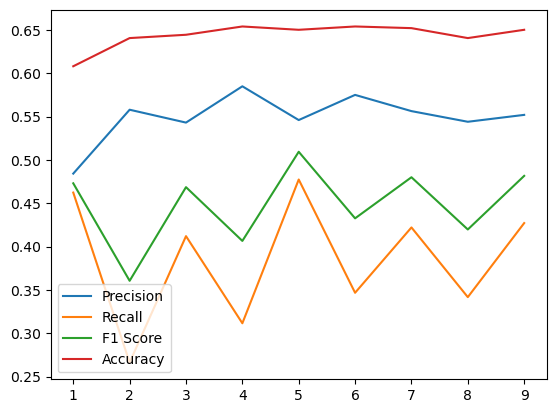

In [182]:
# find the best k value based on the precision, recall, f1 score and accuracy

precisions = []
recalls = []
f1s = []
accuracies = []
k_max = 10
for k in range(1, k_max):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    precisions.append(precision_score(y_test, y_pred, pos_label='Yes'))
    recalls.append(recall_score(y_test, y_pred, pos_label='Yes'))
    f1s.append(f1_score(y_test, y_pred, pos_label='Yes'))
    accuracies.append(accuracy_score(y_test, y_pred))

# plot the results
sns.lineplot(x=range(1, k_max), y=precisions, label='Precision')
sns.lineplot(x=range(1, k_max), y=recalls, label='Recall')
sns.lineplot(x=range(1, k_max), y=f1s, label='F1 Score')
sns.lineplot(x=range(1, k_max), y=accuracies, label='Accuracy')
plt.xticks(range(1, k_max))
plt.show()

In [183]:
# i think the best k value is 3, because it has the best f1 score and accuracy

Accuracy: 0.64
              precision    recall  f1-score   support

          No       0.69      0.79      0.73       324
         Yes       0.54      0.41      0.47       199

    accuracy                           0.64       523
   macro avg       0.61      0.60      0.60       523
weighted avg       0.63      0.64      0.63       523



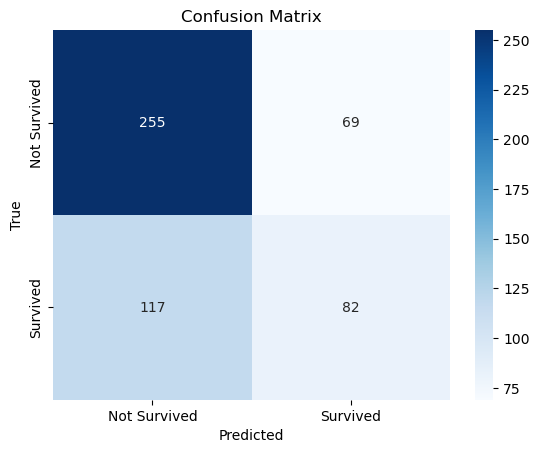

In [184]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived']);
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       324
           1       0.98      0.94      0.96       199

    accuracy                           0.97       523
   macro avg       0.97      0.96      0.97       523
weighted avg       0.97      0.97      0.97       523



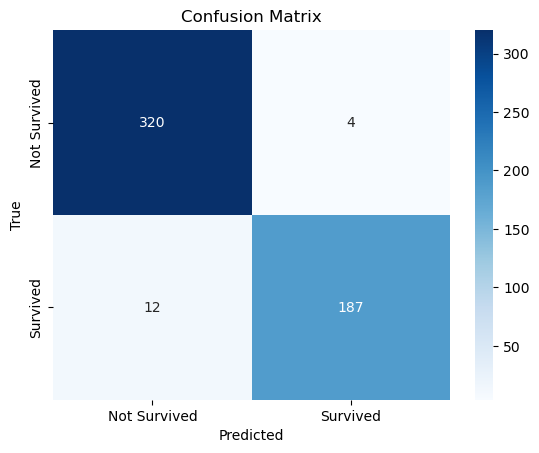

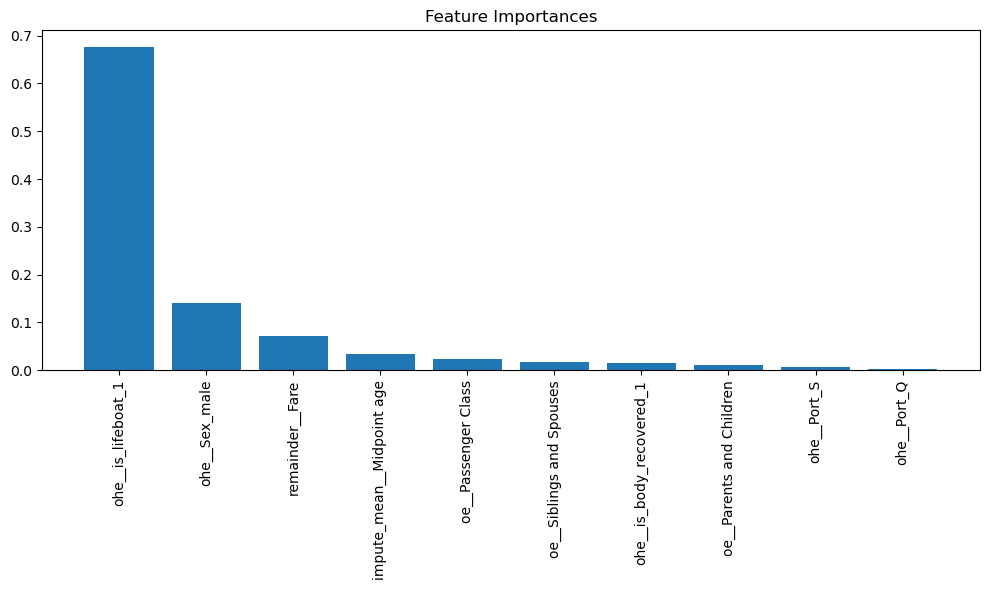

In [185]:
# since at first I did not realize that i can not use the categorical features in KNN, I cleaned
# all the variables, so I think it is worth to try to use them in some other classifier, maybe Random Forest Classifier
X = df.drop(columns=['Survived'])
y = df['Survived']
y = y.map({'No': 0, 'Yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

cols_to_ohe = ['Sex', 'Port', 'is_body_recovered', 'is_lifeboat']
cols_to_oe = ['Passenger Class', 'Siblings and Spouses', 'Parents and Children']
cols_to_mean_impute = ['Midpoint age']

ordering = [
    sorted(df['Passenger Class'].unique()),
    sorted(df['Siblings and Spouses'].unique()),
    sorted(df['Parents and Children'].unique())
]

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cols_to_ohe),
        ('oe', OrdinalEncoder(categories=ordering), cols_to_oe),
        ('impute_mean', SimpleImputer(), cols_to_mean_impute)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_estimators=100))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived']);
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# plot feature importances
importances = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [186]:
# with random forest classifier we are able to achieve 0.97 accuracy
# and we can see that the most important features are the is_lifeboat, Sex and Fare
# lets see how the logistic regression performs using just these 3 features

In [187]:
X = df.drop(columns=['Survived'])
y = df['Survived'].map({'No': 0, 'Yes': 1})
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)
X_df.head(3)

,ohe__Sex_male,ohe__Port_Q,ohe__Port_S,ohe__is_body_recovered_1,ohe__is_lifeboat_1,oe__Passenger Class,oe__Siblings and Spouses,oe__Parents and Children,impute_mean__Midpoint age,remainder__Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27.5,211.3375
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.5,151.5500
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.5,151.5500


In [188]:
X_df = add_constant(X_df)
model = Logit(y, X_df)
result = model.fit()
print(result.summary())

         Current function value: 0.080747
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 1306
Model:                          Logit   Df Residuals:                     1295
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Apr 2025   Pseudo R-squ.:                  0.8785
Time:                        12:12:16   Log-Likelihood:                -105.46
converged:                      False   LL-Null:                       -868.10
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2768      1.032      0.268      0.788      -1.746       2.299
ohe__Sex_male       

/Users/omer/miniforge3/envs/statistics/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [189]:
X = df[['is_lifeboat', 'Sex', 'Passenger Class']].copy()
y = df['Survived'].copy()
X.Sex = (X.Sex == 'male').astype(int)
y = (y == 'Yes').astype(int)
X = add_constant(X)
model = Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.085148
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 1306
Model:                          Logit   Df Residuals:                     1302
Method:                           MLE   Df Model:                            3
Date:                Sat, 12 Apr 2025   Pseudo R-squ.:                  0.8719
Time:                        12:12:16   Log-Likelihood:                -111.20
converged:                       True   LL-Null:                       -868.10
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3661      0.753     -0.486      0.627      -1.842       1.110
is_lifeboat  

Accuracy: 0.97
              precision    recall  f1-score   support

          No       0.97      0.99      0.98       324
         Yes       0.98      0.94      0.96       199

    accuracy                           0.97       523
   macro avg       0.97      0.97      0.97       523
weighted avg       0.97      0.97      0.97       523



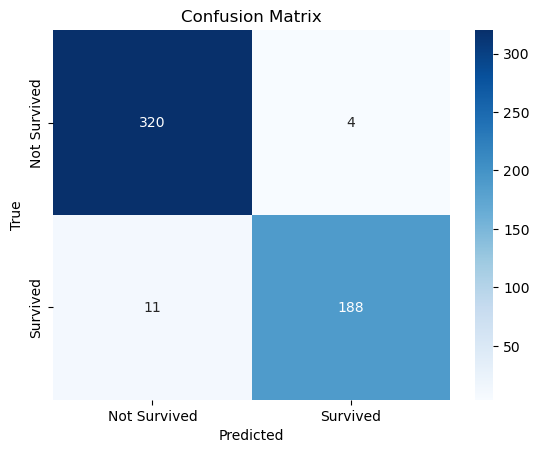

In [190]:
X = df[['is_lifeboat', 'Sex', 'Passenger Class']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
ohe = ['Sex', 'is_lifeboat', 'Passenger Class']
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), ohe)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived']);
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [191]:
# Amazing, logistic regression has the same result as random forest classifier using only 3 features

Frage 1: Was heißt Klassifikationsrate?

Frage 2: Kann man doch KNN mit kategorialen Features benutzen?